In [1]:
%pylab inline
import numpy as np
from tqdm import trange
np.set_printoptions(suppress=True)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# load the mnist dataset
def fetch(url):
  import requests, gzip, os, hashlib, numpy
  fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
  if os.path.isfile(fp):
    with open(fp, "rb") as f:
      dat = f.read()
  else:
    with open(fp, "wb") as f:
      dat = requests.get(url).content
      f.write(dat)
  return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()
X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

In [3]:
# build the neural network
import os
import torch
import torch.nn.functional as F
from torch import nn
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [4]:
# optimizers

class Optimizer:
  def __init__(self, params):
    self.params = [x for x in params]

  def zero_grad(self):
    for param in self.params:
      param.grad = None
      
class SGD(Optimizer):
  def __init__(self, params, lr=0.001):
    super().__init__(params)
    self.lr = lr

  def step(self):
    with torch.no_grad():
      for t in self.params:
        t -= t.grad * self.lr

class Adam(Optimizer):
  def __init__(self, params, lr=0.001, b1=0.9, b2=0.999, eps=1e-8):
    super().__init__(params)
    self.lr, self.b1, self.b2, self.eps, self.t = lr, b1, b2, eps, 0
    self.m = [torch.zeros(*t.shape, requires_grad=False) for t in self.params]
    self.v = [torch.zeros(*t.shape, requires_grad=False) for t in self.params]

  def step(self):
    with torch.no_grad():
      self.t = self.t + 1
      a = self.lr * ((1.0 - self.b2**self.t)**0.5) / (1.0 - self.b1**self.t)
      for i, t in enumerate(self.params):
        self.m[i] = self.b1 * self.m[i] + (1.0 - self.b1) * t.grad
        self.v[i] = self.b2 * self.v[i] + (1.0 - self.b2) * t.grad * t.grad
        t -= a * self.m[i].div(self.v[i].sqrt() + self.eps)

In [5]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
      nn.Linear(28*28, 512),
      nn.ReLU(),
      nn.Linear(512, 512),
      nn.ReLU(),
      nn.Linear(512,10),
    )
  
  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits

In [6]:
class LeNet(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 28, 5)
        
        self.fc1 = nn.Linear(28 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x
print(LeNet())

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 28, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=448, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


Loss 0.10 Accuracy 0.97: 100%|██████████| 1000/1000 [00:07<00:00, 128.09it/s]


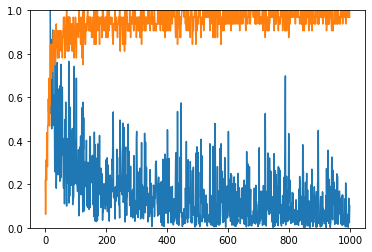

In [7]:
model = LeNet()
#training
losses, accuracies = [],[]
loss_fn = nn.CrossEntropyLoss(reduction='mean')
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum = 0)
optimizer = Adam(model.parameters())
for i in (t:=trange(1000)):
  samp = np.random.randint(0, X_train.shape[0], 32)
  X = torch.from_numpy(X_train[samp]).unsqueeze(1).float()
  y = torch.from_numpy(Y_train[samp])
  model.zero_grad()
  #pred and loss
  pred = model(X)
  pred_x = torch.argmax(pred, dim=1)
  accuracy = (pred_x == y).float().mean()
  loss = loss_fn(pred, y)
#   loss = loss.mean()  ==  reduction='mean'
  
  #back propagation
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  
  losses.append(loss.item())
  accuracies.append(accuracy.item())
  t.set_description("Loss %.2f Accuracy %.2f" % (loss, accuracy))
#plot
plt.ylim(0, 1)
plot(losses)
plot(accuracies)

In [8]:
### model
# Y_test_preds = torch.argmax(model(torch.tensor(X_test.reshape((-1, 28*28))).double()), dim=1).numpy()
# (Y_test == Y_test_preds).mean()

### for LeNet
Y_test_preds = torch.argmax(model(torch.tensor(torch.from_numpy(X_test)).unsqueeze(1).float()), dim=1).numpy()
(Y_test == Y_test_preds).mean()

<ipython-input-8-bc80bb343b01>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_test_preds = torch.argmax(model(torch.tensor(torch.from_numpy(X_test)).unsqueeze(1).float()), dim=1).numpy()


0.9779

(<matplotlib.image.AxesImage at 0x12f37be20>, 6)

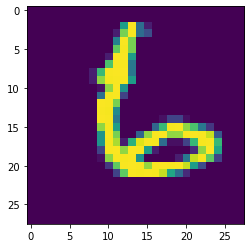

In [54]:
i = int(np.random.randint(0,X_test.shape, 1))
imshow(X_test[i]), Y_test_preds[i]